# **Lane detection using Hough's Transform**


Early research activities in computer vision included several  attepts to refine the edge detection in photos. The goal was always to extract as much information from images computationally and enable the  system to gain a better understanding of the world though the digital images.


**canny edge detection** -   the introduction of Canny edge detection was a huge step up from the existing edge detction approaches, which included the use of sobel operator or the prewitt operator.The treadiional approaches often yielded noise edge maps and were unpleasant to eyes. Canny edge detection enabled a more robust and relatively noise-free edge detection.

**Hough's tranform** -  Hough's transform is a simple algorithm that employs  edge detection like the `canny` edge detection to identify simple geometric shapes like like circles, ellipses or quadrilatterals and lines from the image.  

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In this note book we demonstate a simple program to implement a lane detection algorithm using Hough's transform.

(<Axes: title={'center': 'grayscale'}>,
 Text(0.5, 1.0, 'grayscale'))

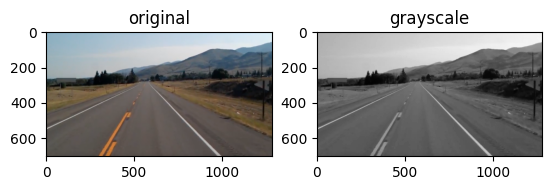

In [ ]:
img = cv2.imread("lane.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1), plt.title("original"), plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 2, 2), plt.imshow(gray, cmap = "gray"), plt.title("grayscale")


We apply `Gaussian blurring` which convolves the image with a kernal that has values that are sampled from a normal distribution. This is also known as a low pass filter as it filters out all the noise (high freqency, allowing only low freq info to pass through) from  the images and helps in minimising detection of false edges(i.e noise in images that may sometimes be detected as edges).

(<matplotlib.image.AxesImage at 0x7db7c417c1c0>,
 Text(0.5, 1.0, 'Gaussian blurred'))

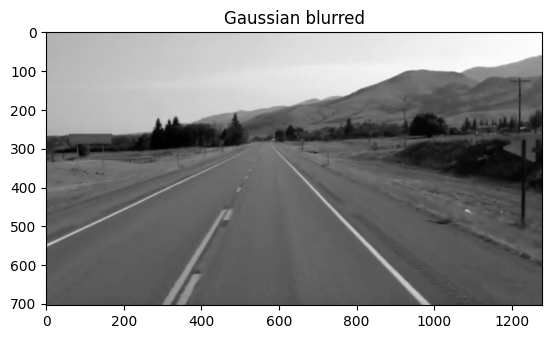

In [ ]:
blur = cv2.GaussianBlur(gray, (5, 5), 1)
plt.imshow(blur, cmap = "gray"), plt.title("Gaussian blurred")


We utilise the cv2 implementation of `Canny` edge detector here to find the edges.


The canny edge detection  is the first edge detection algorithm that utilises the direction of the gradient to find the edges in images. It uses a technique called non maximum supression to identify local maximas edge pixels. It also uses double thresholding to decide wether a pixel is a edge pixel or not.

(<matplotlib.image.AxesImage at 0x7db7c3f59c00>,
 Text(0.5, 1.0, 'Canny edge detection'))

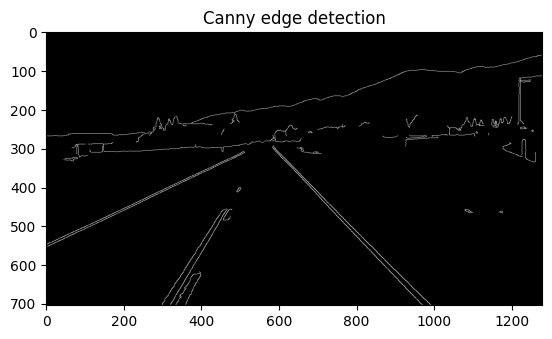

In [ ]:
canny = cv2.Canny(blur, 50, 150)  # to obtain edges of the image
plt.imshow(canny, cmap = "gray"), plt.title("Canny edge detection")


we extract the region of interst and isolate the portion of the image that contains the road  further identify lanes. For this we create a mask and apply bit wise addition with the grayscaled image.

(<matplotlib.image.AxesImage at 0x7db7c3f28c70>,
 Text(0.5, 1.0, 'masked'),
 (-0.5, 1278.5, 703.5, -0.5))

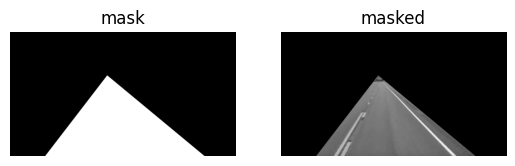

In [ ]:

height = gray.shape[0]
polygons = np.array([

[(200, height), (1100, height), (550, 250)]

])
mask = np.zeros_like(gray)
cv2.fillPoly(mask, polygons, 255)


masked_image = cv2.bitwise_and(gray, mask)



# cropped_image = region_of_interest(canny)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap = "gray"), plt.title("mask"),  plt.axis("off")

plt.subplot(1, 2, 2)
# plt.imshow(cv2.bitwise_and(img, mask), cmap = "gray"), plt.title("cropped image")
plt.imshow(masked_image, cmap = "gray"), plt.title("masked"), plt.axis("off")



(<matplotlib.image.AxesImage at 0x7db7c4051ba0>,
 Text(0.5, 1.0, 'ROI : Edge image'),
 (-0.5, 1278.5, 703.5, -0.5))

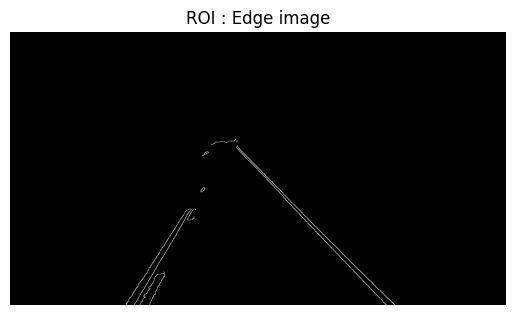

In [ ]:
def region_of_interest(image):
  height = image.shape[0]
  polygons = np.array([
  [(200, height), (1100, height), (550, 250)]
  ])
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, polygons, 255)
  masked_image = cv2.bitwise_and(image, mask)
  return masked_image



cropped_image = region_of_interest(canny)
plt.imshow(cropped_image, cmap = "gray"), plt.title("ROI : Edge image"), plt.axis("off")



## **Hough transformation**

Fortunately, openCV already has a function called `cv2.HoughLinesP()` that can be used to do this task for us.

The functions defined below  are as follows -

**`display_lines()`**: We define this function to mark the lines on a black image with similar measurements as the original image and then blend it into our color image.

**`make_coordinates()`**: This will specify the coordinates for us to be able to mark the slope and y-intercept.

**`average_slope_intercept()`**: we first declare two empty lists - left_fit and right_fit which will contain the coordinates of the average lines on the left and coordinates of the lines on the right respectively.





In [ ]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

In [ ]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

In [ ]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

In [ ]:
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

In [ ]:
averaged_lines = average_slope_intercept(img, lines)

In [ ]:
line_image = display_lines(img, averaged_lines)

combo_image = cv2.addWeighted(img, 0.8, line_image, 1, 1)

(<matplotlib.image.AxesImage at 0x7db7c413d060>,
 Text(0.5, 1.0, 'output image'))

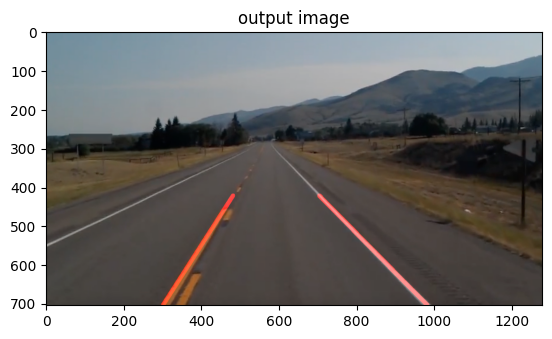

In [ ]:
plt.imshow(combo_image), plt.title("output image"),

the following are the ouputs of  the functions.

In [ ]:
print("lines:\n", lines)
print("\naveraged lines:\n", averaged_lines)

lines:
 [[[650 363 754 467]]

 [[786 513 970 703]]

 [[320 703 451 484]]

 [[399 546 454 461]]

 [[806 521 863 577]]

 [[585 301 631 348]]

 [[592 304 704 416]]

 [[750 465 803 518]]

 [[853 568 941 653]]

 [[393 556 433 495]]

 [[318 671 361 607]]

 [[639 356 777 503]]

 [[704 418 766 480]]

 [[737 460 776 501]]

 [[358 609 435 491]]]

averaged lines:
 [[301 704 482 422]
 [983 704 704 422]]


(<matplotlib.image.AxesImage at 0x7db7c41442e0>,
 Text(0.5, 1.0, 'output image without averaging'))

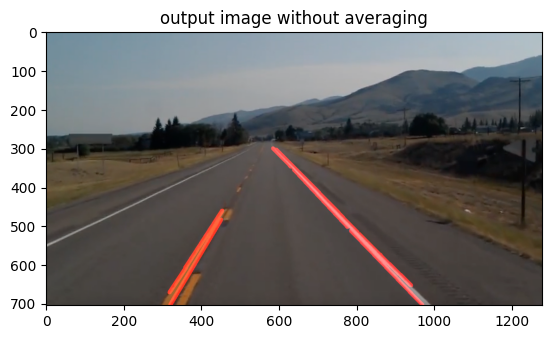

In [ ]:
line_image = display_lines(img, lines.reshape(-1, 4))
combo_image = cv2.addWeighted(img, 0.8, line_image, 1, 1)
plt.imshow(combo_image), plt.title("output image without averaging"),

Lane detection in a video.

In [ ]:
import cv2
import numpy as np

def detect_lanes(frame):
    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blur, 50, 150)

    # Define region of interest (ROI)
    height, width = frame.shape[:2]
    mask = np.zeros_like(edges)
    polygon = np.array([[(0, height), (width/2, height/2), (width, height)]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Apply Hough Transform to detect lines
    lines = cv2.HoughLinesP(masked_edges, rho=2, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=50)

    # Draw detected lines on the original frame
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 5)

    return frame

# Open video file
cap = cv2.VideoCapture('test2.mp4')

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (width, height))

# Process video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect lanes in the frame
    processed_frame = detect_lanes(frame)

    # Write processed frame to output video
    out.write(processed_frame)

# Release video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
# cap = cv2.VideoCapture('test2.mp4')
# while(cap.isOpened()):
#     _, frame = cap.read()
#     canny_image = canny(frame)
#     cropped_image = region_of_interest(canny_image)
#     lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
#     averaged_lines = average_slope_intercept(frame, lines)
#     line_image = display_lines(frame, averaged_lines)
#     combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
#     cv2.imshow('result',combo_image)
#     if cv2.waitKey(1) == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()